### Optionally install required Python packages (uncomment lines as needed)

In [1]:
# !pip install requests
# !pip install ipywidgets
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install plotly

### Set the URLs of the time-series service endpoints

In [2]:
service_base_url    = 'https://app.openskope.org/timeseries-service/api/v1'
status_endpoint     = service_base_url + "/status"
version_endpoint    = service_base_url + "/version"
timeseries_endpoint = service_base_url + "/timeseries"

### Exercise the status endpoint

In [3]:
import requests

In [4]:
print(requests.get(status_endpoint).json())

{u'name': u'SKOPE Timeseries Service'}


### Exercise the version endpoint

In [5]:
print(requests.get(version_endpoint).text)

-----------------------------------------------------------------------------
SKOPE Time-Series Service v0.2.0-0 (branch master, commit 6c24801)
-----------------------------------------------------------------------------
Remote repo: https://github.com/openskope/timeseries-service.git
Git branch: master
Last commit: 6c2480145a827966c1bf9d2a57b8c0bf25d8c0e3
Commit time: 2018-05-07T21:37:24+0000
Most recent tag: v0.2.0
Commits since tag: 0
Builder name: 
Builder email: tmcphillips@absoluteflow.org
Build host: 460ae1080878
Build platform: Linux 4.4.0-93-generic (amd64)
Build Java VM: OpenJDK 64-Bit Server VM (Oracle Corporation)
Build Java version: JDK 1.8.0_171
Build time: 2018-05-07T22:41:33+0000



### Select the data set, variable, and time range for time series

In [6]:
import ipywidgets as widgets
dataset_id = widgets.Text('paleocar_2')
variable_name = widgets.Text('growing_degree_days')
date_range = widgets.IntRangeSlider(description="Year range", min=1, max=2000, value=[1,2000])

display(dataset_id, variable_name, date_range)

Text(value=u'paleocar_2')

Text(value=u'growing_degree_days')

IntRangeSlider(value=(1, 2000), description=u'Year range', max=2000, min=1)

### Request the time series

In [7]:
# build the request body
request_json = {  
    "datasetId"     : dataset_id.value,
    "variableName"  : variable_name.value,
    "start"         : date_range.value[0], 
    "end"           : date_range.value[1], 
    "timeResolution": 'year', 
    "timeZero": 1, 
    "boundaryGeometry": {
        "type": "Point",
        "coordinates": [-106.0,41.0]
    }
}

# make the post request and store the response
response = requests.post(timeseries_endpoint, json=request_json)

# confirm that the request was successful
assert response.status_code == 200

In [8]:
# get the JSON object returned in the response
# get the body of the response as JSON
response_json = response.json()

# confirm that the metadata in the response is as expected
assert response_json['datasetId']    == dataset_id.value
assert response_json['variableName'] == variable_name.value
assert response_json['start']        == str(date_range.value[0])
assert response_json['end']          == str(date_range.value[1])

### Load response csv property into a Pandas dataframe

In [9]:
import pandas as pd
from io import StringIO

# enable the csv property to be read as if it were a file
csv = StringIO(response_json['csv'])

# load the csv content into into a dataframe
df = pd.read_csv(csv)

# display the first 10 rows of the dataframe
print(df.head(10))

   year   growing_degree_days   range -   range +
0     1                  1775    1758.0    1792.0
1     2                  1823    1806.0    1840.0
2     3                  1846    1829.0    1863.0
3     4                  1870    1853.0    1887.0
4     5                  1820    1803.0    1837.0
5     6                  1833    1816.0    1850.0
6     7                  1801    1784.0    1818.0
7     8                  1682    1665.0    1699.0
8     9                  1631    1614.0    1648.0
9    10                  1701    1684.0    1718.0


### Pretty-print five points at beginning and end of time series

In [10]:
from IPython.display import display, HTML
display(HTML(df.to_html(max_rows=10,index=False)))

### Create a static plot of the time series using Matplotlib

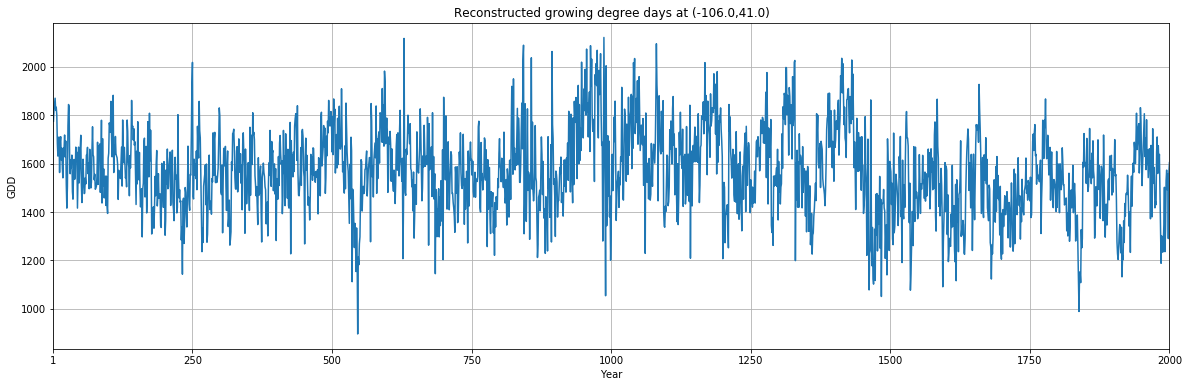

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

timeseries_values = response_json['values']

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)
p = ax.plot(range(1,2001), timeseries_values[:2000])
ax.set_title("Reconstructed growing degree days at (-106.0,41.0)")
ax.set_xlabel("Year")
ax.set_ylabel("GDD")
ax.set_xlim(1,2000)
ax.set_xticks([1] + list(plt.xticks()[0][1:-1]) + [2000]);
ax.grid(True)

### Create an interactive plot with range slider using Plotly

In [12]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

start_year, end_year = date_range.value
years = list(range(start_year, end_year+1))
values = response_json['values']

fig = dict(
    data = [{"x": years, "y": values}], 
    layout = dict(
        title='Time Series with Rangeslider',
        xaxis=dict(rangeselector=dict(), rangeslider=dict())
    )
)

iplot(fig)